In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import uuid
from architectures import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchcam.methods import GradCAM
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype, normalize
from torchvision.utils import save_image
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37
ROOT_PATH = os.getcwd()
os.makedirs(LOGS_PATH := os.path.join(ROOT_PATH, "logs"), exist_ok=True)
os.makedirs(RAW_DATASET_PATH := os.path.join(ROOT_PATH, "dataset", "raw"), exist_ok=True)
os.makedirs(PRODUCTION_DATASET_PATH := os.path.join(ROOT_PATH, "dataset", "production"), exist_ok=True)
os.makedirs(MODELS_PATH := os.path.join(ROOT_PATH, "models"), exist_ok=True)

SUBSAMPLE_SIZE = 10000
NOISE_RATIO = 0.5
EARTHQUAKE_RATIO = 0.5

PROCESSING_METHOD = 1

BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7

seed_functions(SEED)

c:\Users\gregory\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessing

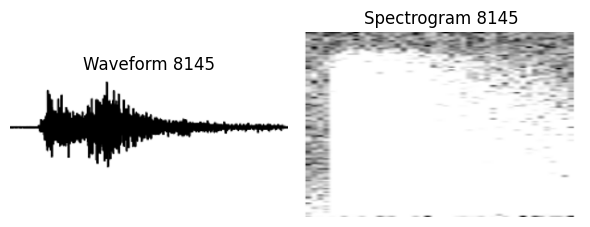

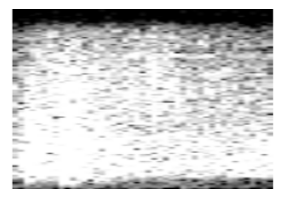

In [2]:
def preprocess_data():
	"""Computes, saves, and prints summary of preprocessed data."""
	# Compute preprocessed data
	data_processor = DataPreprocessing(
		subsample_size=SUBSAMPLE_SIZE,
		raw_dataset_path=RAW_DATASET_PATH,
		logs_path=LOGS_PATH,
		noise_ratio=NOISE_RATIO,
		earthquake_ratio=EARTHQUAKE_RATIO
	)

	# Save preprocessed data
	signals = data_processor.subsample_traces
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"signals_{SUBSAMPLE_SIZE}.npy"), np.array(list(signals.values())))
	metadata = data_processor.subsample_metadata
	metadata.to_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
	waveform_images = data_processor.create_waveform_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"), waveform_images)
	spectrogram_images = data_processor.create_spectrogram_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"), spectrogram_images)

	# Print summary of preprocessed data
	print(f"""
	1. Expected samples: {SUBSAMPLE_SIZE}
	2. Actual samples: {len(signals)}\n{metadata['category'].value_counts(normalize=True)}
	""")

# preprocess_data()

def visualise_data(num_samples=1):
	"""Randomly selects and plots annotated waveform and spectrogram images."""
	# Load saved images
	waveform_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"))
	spectrogram_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))

	# Create figure with subplots
	fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

	# Ensure axes is iterable for a single sample case
	if num_samples == 1: axes = [axes]

	# Plot random images
	for i1, i2 in enumerate(np.random.choice(len(waveform_images), num_samples, replace=False)):
		axes[i1][0].imshow(waveform_images[i2])
		axes[i1][0].set_title(f"Waveform {i2}")
		axes[i1][0].axis("off")
		axes[i1][1].imshow(spectrogram_images[i2])
		axes[i1][1].set_title(f"Spectrogram {i2}")
		axes[i1][1].axis("off")
	plt.tight_layout()
	plt.show()

visualise_data()

def visualise_raw_data(num_samples=1):
	"""Randomly selects and plots a raw spectrogram image."""
	# Load raw spectrogram model inputs
	spectrogram_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))

	# Select random samples
	indices = np.random.choice(len(spectrogram_images), num_samples, replace=False)

	# Plot images
	fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
	if num_samples == 1:
		axes = [axes]

	for ax, idx in zip(axes, indices):
		img = spectrogram_images[idx]
		ax.imshow(img)
		ax.axis("off")

	plt.tight_layout()
	plt.show()

visualise_raw_data()

Loading

In [3]:
model = SCNNQ730().to(DEVICE) if PROCESSING_METHOD == 1 else BiLSTMF().to(DEVICE)
print(model)

# Compute labels
metadata = pd.read_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
labels = (metadata["category"] == "earthquake").astype(np.float32).values  # 0 (noise), 1 (earthquake)
labels = torch.tensor(labels).view(-1, 1)

def split_data(data, labels, test_size=0.2, dev_size=0.5):
	"""Returns matching index-label pairs needed to split dataset."""
	train_i, temp_i, train_labels, temp_labels = train_test_split(
		data, labels, test_size=test_size, stratify=labels, random_state=SEED
	)
	dev_i, test_i, dev_labels, test_labels = train_test_split(
		temp_i, temp_labels, test_size=dev_size, stratify=temp_labels, random_state=SEED
	)
	return train_i, train_labels, dev_i, dev_labels, test_i, test_labels

if PROCESSING_METHOD == 1:
	spectrograms = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))
	spectrograms = torch.tensor(spectrograms.astype(np.float32) / 255.0).permute(0, 3, 1, 2)
	train_i, train_labels, dev_i, dev_labels, test_i, test_labels = split_data(spectrograms, labels)

	def load_data(model):
		"""Prepares data loaders for models taking spectrogram images as input."""
		train_generator = torch.Generator()
		train_generator.manual_seed(SEED)

		if getattr(model, "expects224", False):
			train_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(train_i, train_labels)), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
			dev_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(dev_i, dev_labels)), batch_size=BATCH_SIZE, shuffle=False)
			test_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(test_i, test_labels)), batch_size=BATCH_SIZE, shuffle=False)
			return train_loader, dev_loader, test_loader

		train_loader = DataLoader(SpectrogramDataset(train_i, train_labels), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
		dev_loader = DataLoader(SpectrogramDataset(dev_i, dev_labels), batch_size=BATCH_SIZE, shuffle=False)
		test_loader = DataLoader(SpectrogramDataset(test_i, test_labels), batch_size=BATCH_SIZE, shuffle=False)
		return train_loader, dev_loader, test_loader

	train_loader, dev_loader, test_loader = load_data(model)
else:
	signals = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"signals_{SUBSAMPLE_SIZE}.npy"))
	signal_envelopes = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=True) for raw_signal in signals])
	signal_envelopes = torch.tensor(signal_envelopes.astype(np.float32)).unsqueeze(-1)
	train_i, train_labels, dev_i, dev_labels, test_i, test_labels = split_data(signal_envelopes, labels)

	def load_data():
		"""Prepares data loaders for models taking padded envelopes as input."""
		train_generator = torch.Generator()
		train_generator.manual_seed(SEED)

		train_loader = DataLoader(SpectrogramDataset(train_i, train_labels), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
		dev_loader = DataLoader(SpectrogramDataset(dev_i, dev_labels), batch_size=BATCH_SIZE, shuffle=False)
		test_loader = DataLoader(SpectrogramDataset(test_i, test_labels), batch_size=BATCH_SIZE, shuffle=False)
		return train_loader, dev_loader, test_loader

	train_loader, dev_loader, test_loader = load_data()

SCNNQ730(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (su): SomnialUnit(
    (generator): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Identity()
    )
  )
  (fc1): Linear(in_features=59200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Training

In [ ]:
def train_model(model, train_loader, dev_loader, criterion, optimizer):
	"""Trains a model with early stopping, checkpoints, and loss saves."""
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch: {epoch+1} of {NUM_EPOCHS} - Training loss: {train_loss:.4f} - Validation loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))
		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_model(model, train_loader, dev_loader, criterion, optimizer)

Post-training

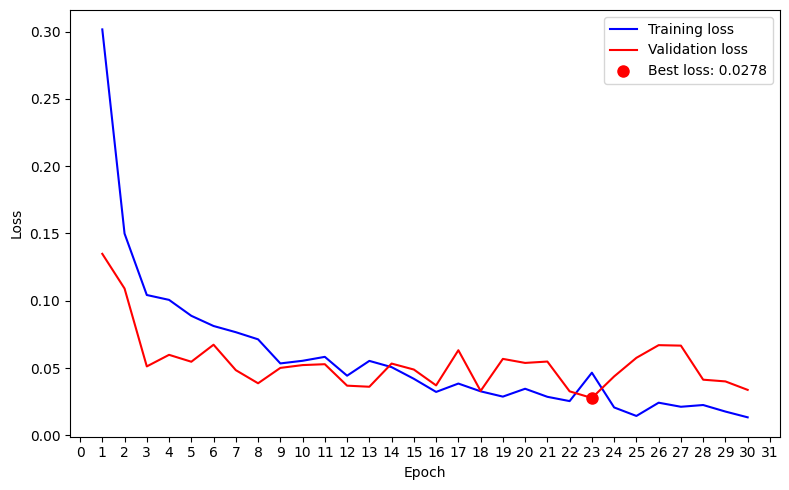

In [4]:
def visualise_loss(model):
	"""Plots training and validation losses for a trained model."""
	# Load losses
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	with open(os.path.join(model_folder, "losses.json"), "r") as f:
		loss_data = json.load(f)
	train_losses = loss_data["train_losses"]
	dev_losses = loss_data["dev_losses"]

	plt.figure(figsize=(8, 5))
	epochs = range(1, len(train_losses) + 1)
	plt.plot(epochs, train_losses, "b-", label="Training loss")
	plt.plot(epochs, dev_losses, "r-", label="Validation loss")

	# Annotate the best loss
	best_epoch = np.argmin(dev_losses) + 1
	best_loss = min(dev_losses)
	plt.plot(best_epoch, best_loss, "ro", markersize=8, label=f"Best loss: {best_loss:.4f}")

	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
	plt.tight_layout()
	plt.show()

# M = [SR50ViTB16(), SCNNQ730()]
# multivisualise_training_loss(M)
# multivisualise_validation_loss(M)

m = model.__class__().to(DEVICE)
visualise_loss(m)

In [5]:
def evaluate_model(model, dataloader):
	"""Evaluates a model on a dataloader to return a binary confusion matrix and a macro F1 score."""
	model.eval()
	Y_hat, Y = [], []
	with torch.no_grad():
		for x, y in dataloader:
			Y_hat.append(model(x.to(DEVICE)).round().cpu())
			Y.append(y)
	tn, fp, fn, tp = confusion_matrix(torch.cat(Y), torch.cat(Y_hat)).ravel()
	f1 = compute_macro_f1(tp, tn, fp, fn)
	return {
		"tp": int(tp),
		"tn": int(tn),
		"fp": int(fp),
		"fn": int(fn),
		"f1": float(f1)
	}

def load_weights(model):
	"""Loads the best (lowest-dev-loss) saved weights into a given model."""
	state_dict = torch.load(os.path.join(MODELS_PATH, model.id, "best.pth"), weights_only=False)
	state_dict.pop("_metadata", None)
	model.load_state_dict(state_dict)

m = model.__class__().to(DEVICE)
load_weights(m)
print(evaluate_model(m, test_loader))

{'tp': 495, 'tn': 497, 'fp': 3, 'fn': 5, 'f1': 0.9919999679998719}


tensor([[0.7721]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_14_19_label0_pred1.png


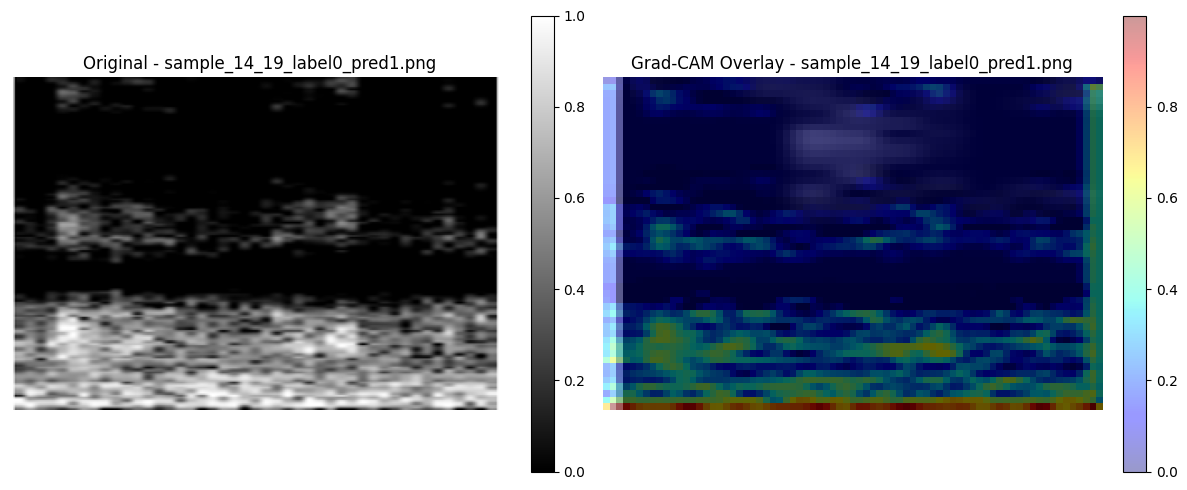

tensor([[0.9846]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_18_19_label0_pred1.png


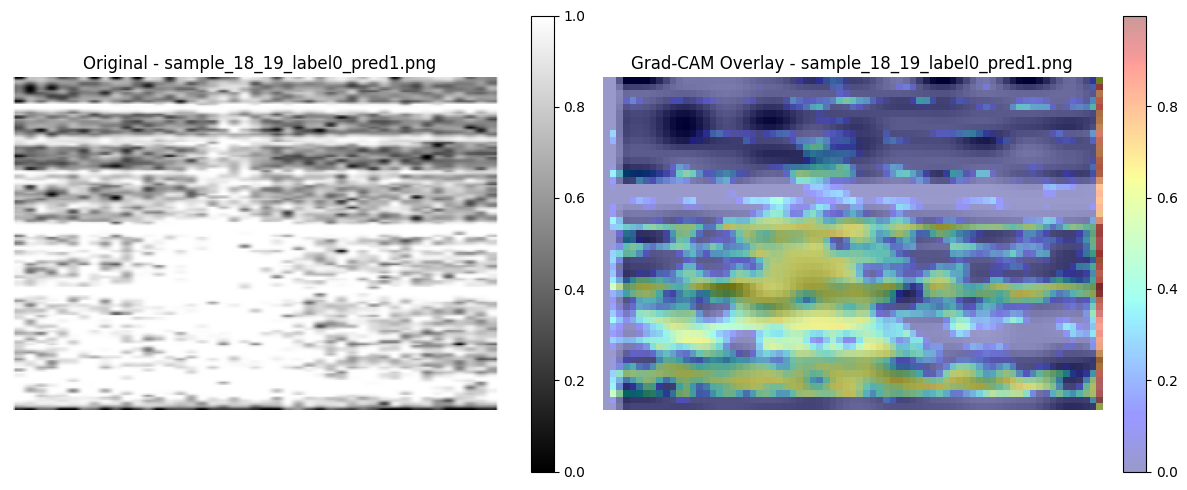

tensor([[0.9396]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_18_31_label0_pred1.png


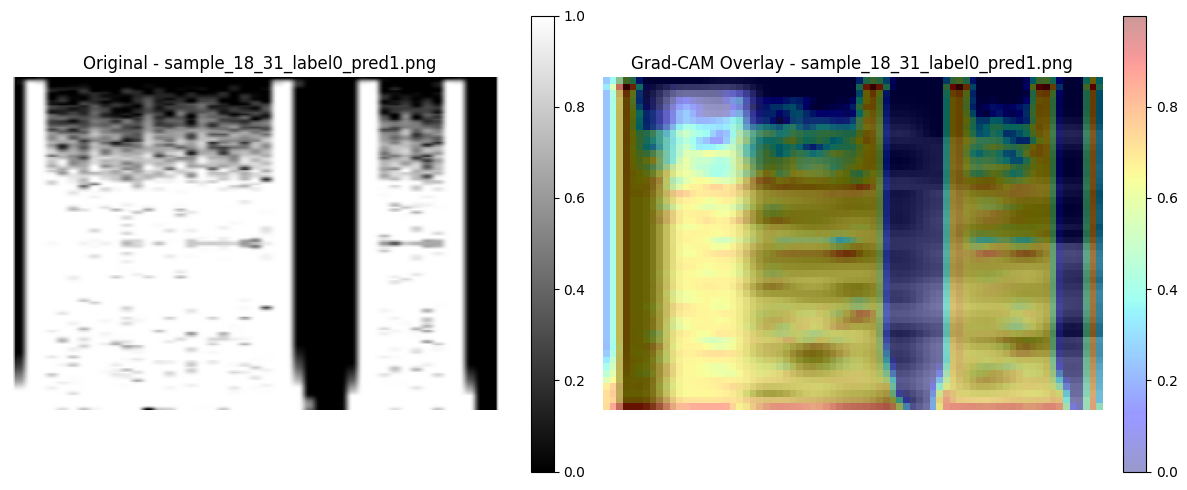

tensor([[0.5917]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_20_28_label0_pred1.png


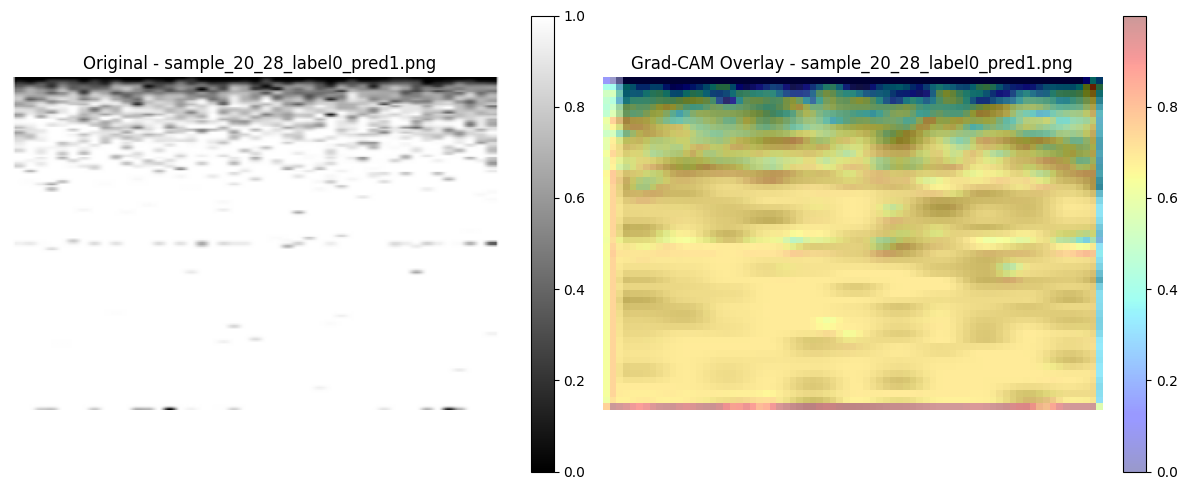

tensor([[0.7978]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_21_0_label0_pred1.png


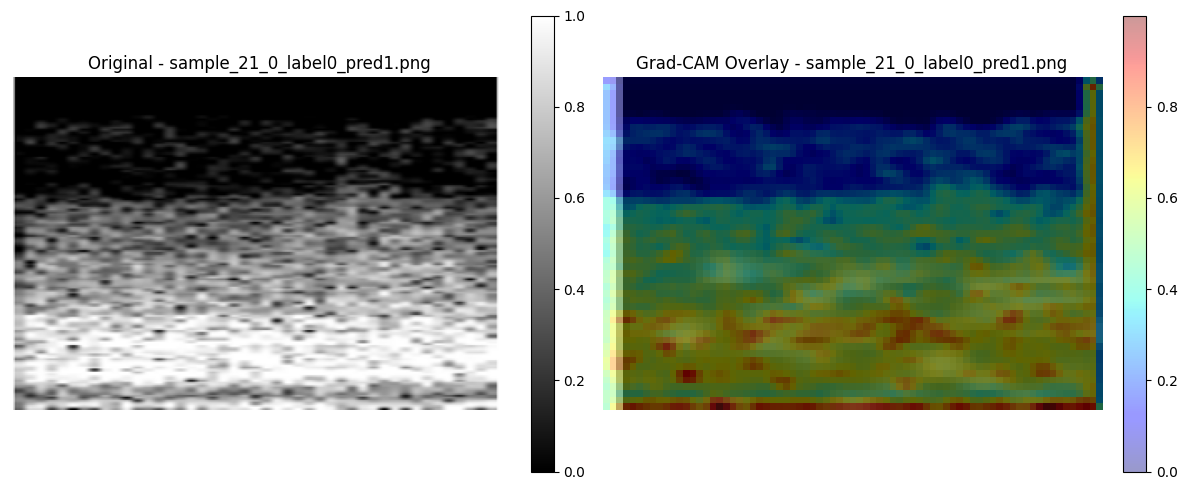

tensor([[0.7781]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_22_19_label0_pred1.png


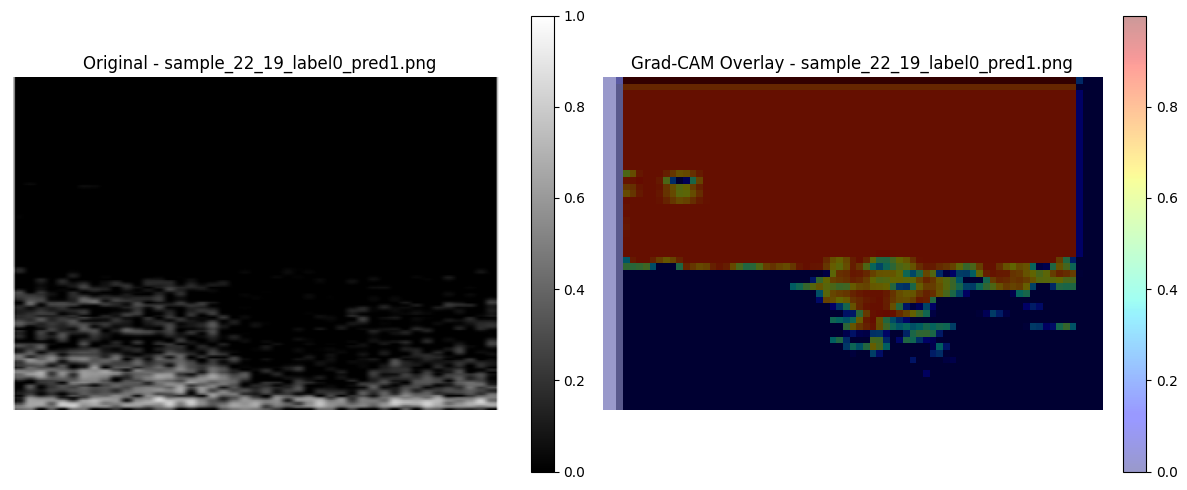

tensor([[0.3047]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_23_5_label1_pred0.png


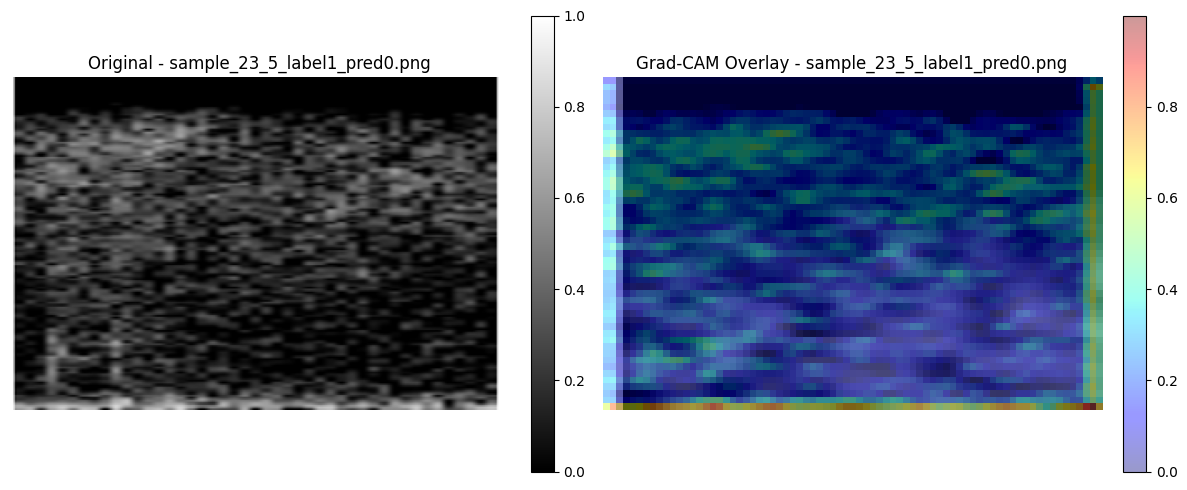

tensor([[0.2775]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_25_18_label1_pred0.png


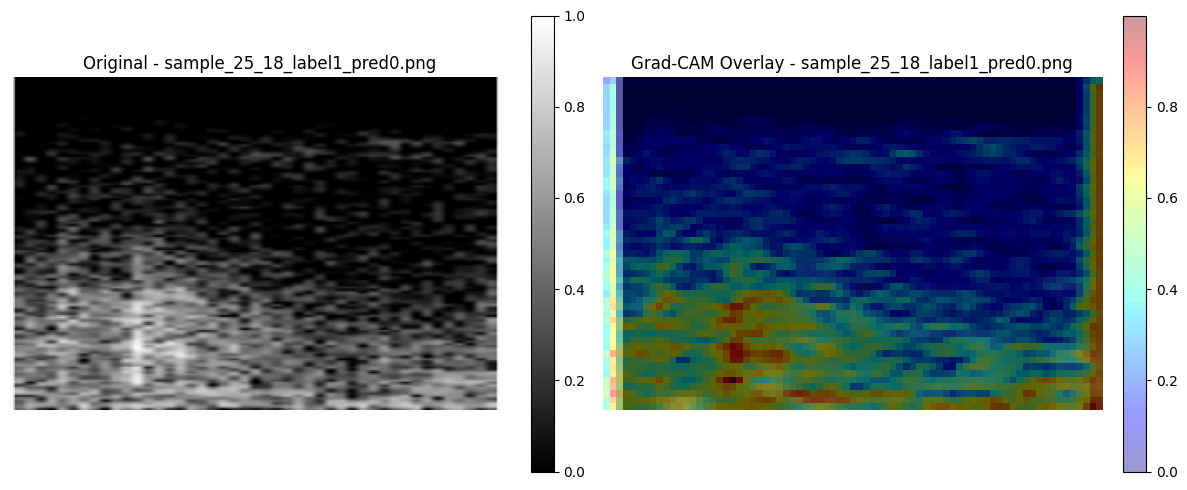

tensor([[0.8192]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_30_23_label0_pred1.png


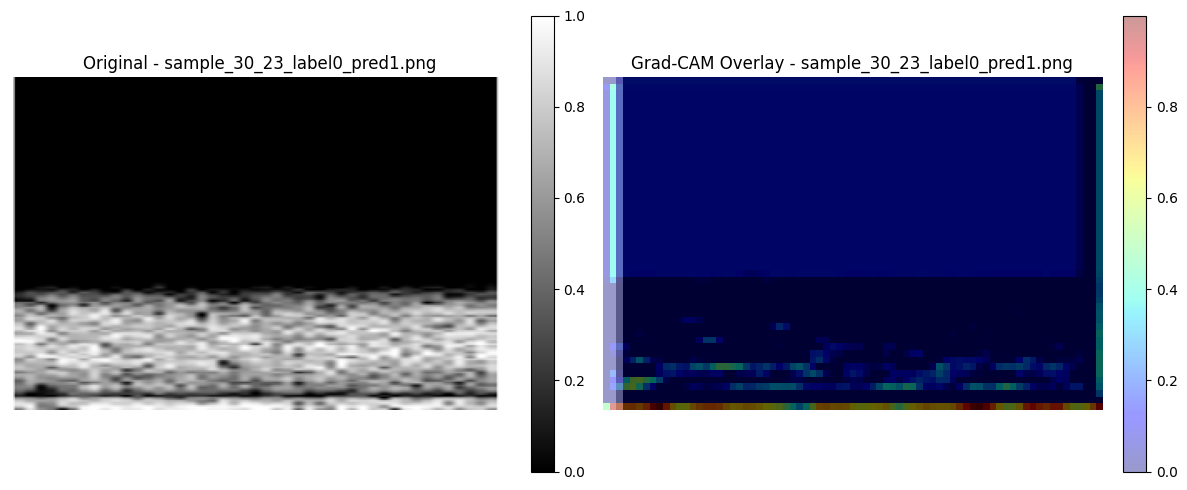

tensor([[0.0031]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Processing sample_8_4_label1_pred0.png


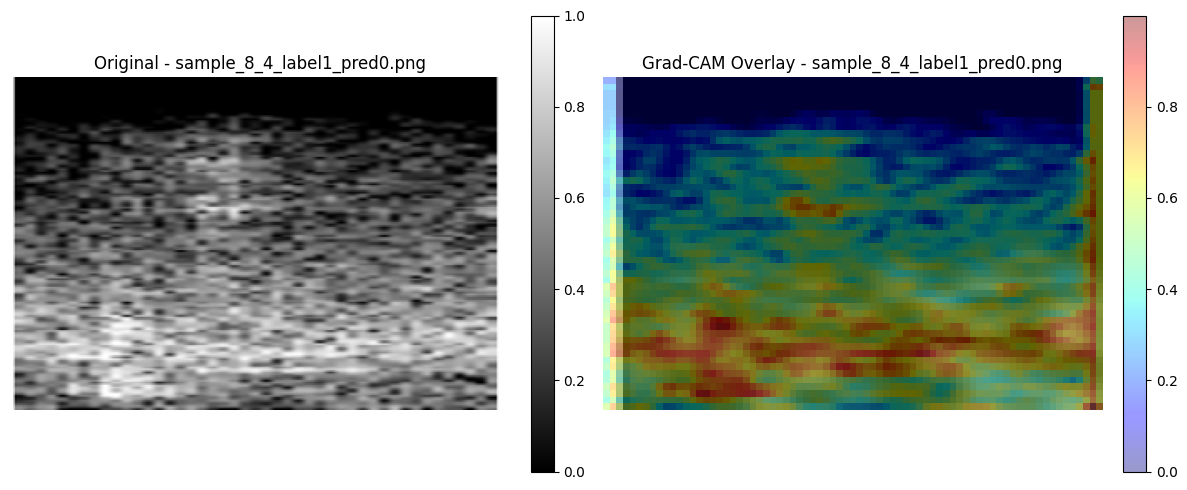

In [6]:
def save_SCNNQ730_samples(dataloader):
	"""Saves image results for where SCNNQ730 succeeded or failed, for Grad-CAM analysis."""
	save_misclassified_dir = "SCNNQ730_misclassified"
	save_classified_dir = "SCNNQ730_classified"

	model = SCNNQ730().to(DEVICE)
	load_weights(model)
	model.eval()

	os.makedirs(save_misclassified_dir, exist_ok=True)
	os.makedirs(save_classified_dir, exist_ok=True)

	Y_hat, Y = [], []
	tp_to_save = 5
	tn_to_save = 5

	with torch.no_grad():
		for batch_idx, (x, y) in enumerate(dataloader):
			x, y = x.to(DEVICE), y.to(DEVICE)
			y_pred = model(x).round()
			Y_hat.append(y_pred.cpu())
			Y.append(y.cpu())

			for i in range(x.size(0)):
				label = int(y[i].item())
				pred = int(y_pred[i].item())
				filename = f"sample_{batch_idx}_{i}_label{label}_pred{pred}.png"
				if pred != label:
					save_image(x[i].cpu(), os.path.join(save_misclassified_dir, filename))
				elif (label == 1 and tp_to_save > 0) or (label == 0 and tn_to_save > 0):
					save_image(x[i].cpu(), os.path.join(save_classified_dir, filename))
					if label == 1:
						tp_to_save -= 1
					else:
						tn_to_save -= 1
	return

def show_SCNNQ730_grads():
	"""Generates Grad-CAM overlays for SCNNQ730."""
	image_folder = "SCNNQ730_misclassified"

	model = SCNNQ730().to(DEVICE)
	load_weights(model)
	model.eval()

	cam_extractor = GradCAM(model, target_layer=model.conv3)

	for filename in os.listdir(image_folder):
		if filename.endswith(".png"):
			image_path = os.path.join(image_folder, filename)
			image = read_image(image_path)
			image = convert_image_dtype(image, dtype=torch.float32)
			out = model(image.unsqueeze(0).to(DEVICE))
			print(out)
			activation_map = cam_extractor(out.squeeze().argmax().item(), out)
			image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
			cam = activation_map[0].squeeze().cpu().numpy()

			print(f"Processing {filename}")

			fig, axes = plt.subplots(1, 2, figsize=(12, 5))

			axes[0].imshow(image_np, cmap="gray")
			axes[0].set_title(f"Original - {filename}")
			axes[0].axis("off")
			fig.colorbar(axes[0].imshow(image_np, cmap="gray"), ax=axes[0], fraction=0.046, pad=0.04)

			axes[1].imshow(image_np, cmap="gray")
			im = axes[1].imshow(cam, cmap="jet", alpha=0.4)
			axes[1].set_title(f"Grad-CAM Overlay - {filename}")
			axes[1].axis('off')
			fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

			plt.tight_layout()
			plt.show()

save_SCNNQ730_samples(dev_loader)
show_SCNNQ730_grads()